### Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.dataset import ISICDataset
from definitions import ISIC_DIR

### Dataset Loading

In [2]:
dataset = ISICDataset(ISIC_DIR)

- Without artifact

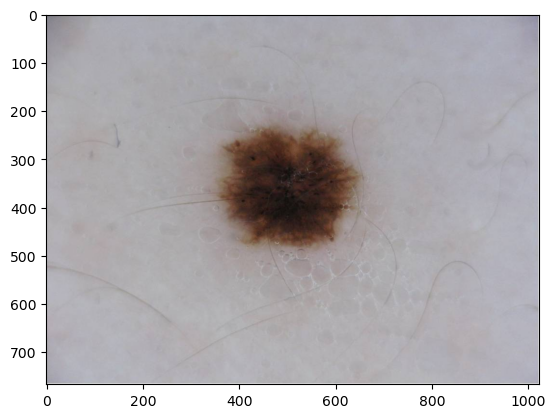

In [3]:
sample0 = dataset[1]
plt.imshow(sample0['image'])

- With artifacts

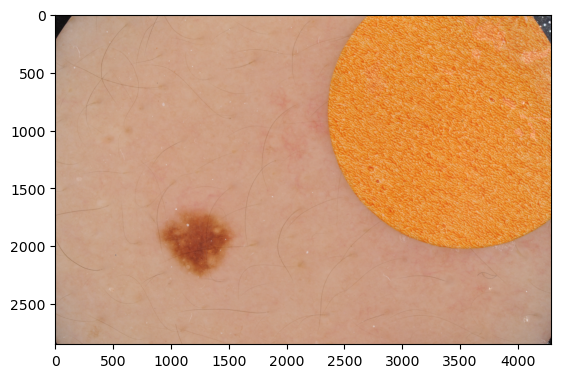

In [4]:
sample1 = dataset[478]
plt.imshow(sample1['image'])

### Artifacts detection

In [5]:
def get_mask(image : np.ndarray):
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Get binary mask
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Countour detection
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Get the largest contour
    c = max(contours, key = cv2.contourArea)

    # Create a mask with the largest contour
    mask = np.zeros_like(mask)
    cv2.drawContours(mask, [c], -1, 255, -1)

    return mask

In [6]:
def visualize(image : np.ndarray, mask : np.ndarray):
    
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    object_ = image * mask[:, :, None].astype(bool)

    ax[0].imshow(image)
    ax[0].set_title('Image')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Mask')

    ax[2].imshow(object_)
    ax[2].set_title('Object')


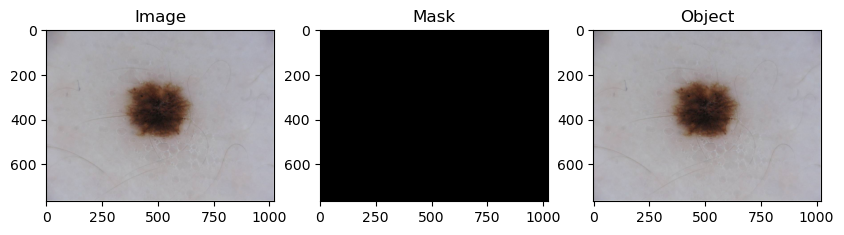

In [7]:
mask = get_mask(np.array(sample0['image']))
visualize(np.array(sample0['image']), mask)

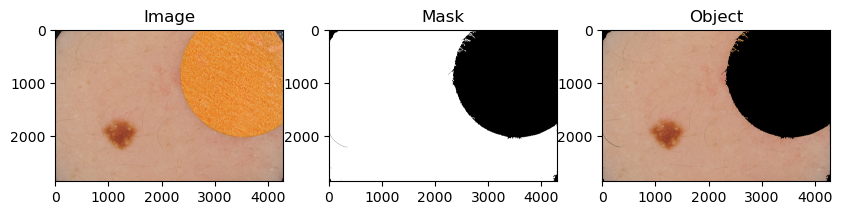

In [8]:
mask = get_mask(np.array(sample1['image']))
visualize(np.array(sample1['image']), mask)